# Imports

In [1]:
#from google.colab import drive
from datetime import datetime
import pandas as pd
import requests

# BBData Workshop

BBData est une plateforme de stockage de séries temporelles. Ce genre de données est définie comme étant une suite de données. Chaque élément de cette suite est composé d'un indice temporel et d'une valeur.

https://fr.wikipedia.org/wiki/S%C3%A9rie_temporelle


## Concepts

Quatre éléments à retenir, du côté utilisateur : 

  - User
  - User Groups

Et du côté capteur :
  
  - Object Group
  - Object

### Liens

- https://daplab.gitlab.io/bbdata-docs/resources/rights.png
- https://daplab.gitlab.io/bbdata-docs/conception/


## Création de l'infrastructure de stockage

Avant de stocker de la donnée dans BBData, il est bon de voir comment le faire avec un administrateur; Jonathan Rial ou moi. Nous sommes là pour vous aider. 

L'installation est simple et prend quelques minutes. Pour résumer, voici les différentes étapes:

1. Créer un User Group pour le projet en question
2. Associer (éventuellement créer) des utilisateurs à ce User Group
3. Créer un Object Group et y associer un User Group
4. Créer des Object et les associers à un Object Group

Une fois cela fait, il est possible d'utiliser BBData pour le stockage et l'acquisition de donnée.

Aussi, dans le cas ou il y a une quantité importante de capteurs, il est possible de scripter ce processus. 

Chargons les données avec Pandas

In [2]:
data = pd.read_csv("myfile.csv")
#data = data[101:200] # TODO - delete this line

In [3]:
data.timestamp = data.timestamp.apply(lambda t: datetime.strptime(t, "%Y-%m-%d %H:%M:%S"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10 non-null     datetime64[ns]
 1   value      10 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 288.0 bytes


In [4]:
data

,timestamp,value
0,2016-11-14 23:44:32,1.20
1,2016-11-14 23:49:34,1.20
2,2016-11-14 23:54:38,1.28
3,2016-11-14 23:59:40,1.28
4,2016-11-15 00:04:42,1.44
5,2016-11-15 07:38:40,2.08
6,2016-11-15 07:43:44,2.24
7,2016-11-15 07:48:46,2.32
8,2016-11-15 07:53:48,2.40
9,2016-11-15 07:58:52,2.24


Déclarer différentes constantes

In [5]:
ENDPOINT = "http://localhost:8080"
USERNAME = "admin"
PASSWORD = "testtest"
USERGROUP = 1 #SUPERADMIN

In [6]:
response = requests.post(ENDPOINT + "/login", json = {"username": USERNAME,"password": PASSWORD})
print(response.text)

USERID = str(response.json()["userId"])
TOKEN = response.json()["secret"]
HEADERS = {"bbuser" : USERID, "bbtoken" : TOKEN}

{
  "id" : 8,
  "secret" : "ada3af48aeca91924ce4312d9d8c615f",
  "expirationDate" : "2022-01-16T13:28:39.425Z",
  "userId" : 1,
  "readOnly" : false,
  "description" : "auto_login"
}


In [7]:
response = requests.put(ENDPOINT + "/objectGroups", headers = HEADERS, json = {"name": "Jupyter","description": "Jupyter notebook","owner": USERGROUP})
print(response.text)
response = requests.put(ENDPOINT + "/objects", headers = HEADERS, json = {
    "name": "Jupyter",
    "description": "Jupyter notebook",
    "owner": USERGROUP,
    "unitSymbol": "V",
    "tags": []})
print("\n\n")
print(response.text)

OBJECT_ID = response.json()["id"]
COMMENT = ""

{
  "id" : 4,
  "name" : "Jupyter",
  "description" : "Jupyter notebook",
  "owner" : {
    "id" : 1,
    "name" : "SUPERADMIN"
  }
}



{
  "id" : 13371,
  "name" : "Jupyter",
  "description" : "Jupyter notebook",
  "unit" : {
    "symbol" : "V",
    "name" : "volt",
    "type" : "float"
  },
  "disabled" : false,
  "creationdate" : "2022-01-16T00:28:42.000Z",
  "owner" : {
    "id" : 1,
    "name" : "SUPERADMIN"
  },
  "tags" : [ ]
}


In [8]:
response = requests.put(ENDPOINT + f"/objects/{str(OBJECT_ID)}/tokens", headers= HEADERS, json = {"description": "Jupyter Notebook"})
print(response.text)

OBJECT_TOKEN = response.json()["token"]

{
  "id" : 6,
  "objectId" : 13371,
  "token" : "2f4e4f93b1f1b223f92e5694144c2198",
  "description" : "Jupyter Notebook"
}


Définition d'une fonction pour convertir une ligne d'un Pandas DataFrame en un objet JSON.

In [9]:
def to_json(obj_data):
  return {"objectId": OBJECT_ID, "token": OBJECT_TOKEN, "timestamp": obj_data.timestamp.isoformat(), "value": str(obj_data.value), "comment": COMMENT}

Conversion du DataFrame en array d'objets JSON


In [10]:
json_data = [to_json(d) for _, d in data.iterrows()]

Envois des données à l'API REST

In [11]:
response = requests.post(ENDPOINT + "/objects/values", json=json_data)

Les données sont maintenant stockées sur BBData

In [12]:
print(response.text)

[ {
  "objectId" : 13371,
  "timestamp" : "2016-11-14T23:44:32.000Z",
  "value" : "1.2",
  "comment" : "",
  "unitName" : "volt",
  "unitSymbol" : "V",
  "type" : "float",
  "owner" : 1
}, {
  "objectId" : 13371,
  "timestamp" : "2016-11-14T23:49:34.000Z",
  "value" : "1.2",
  "comment" : "",
  "unitName" : "volt",
  "unitSymbol" : "V",
  "type" : "float",
  "owner" : 1
}, {
  "objectId" : 13371,
  "timestamp" : "2016-11-14T23:54:38.000Z",
  "value" : "1.28",
  "comment" : "",
  "unitName" : "volt",
  "unitSymbol" : "V",
  "type" : "float",
  "owner" : 1
}, {
  "objectId" : 13371,
  "timestamp" : "2016-11-14T23:59:40.000Z",
  "value" : "1.28",
  "comment" : "",
  "unitName" : "volt",
  "unitSymbol" : "V",
  "type" : "float",
  "owner" : 1
}, {
  "objectId" : 13371,
  "timestamp" : "2016-11-15T00:04:42.000Z",
  "value" : "1.44",
  "comment" : "",
  "unitName" : "volt",
  "unitSymbol" : "V",
  "type" : "float",
  "owner" : 1
}, {
  "objectId" : 13371,
  "timestamp" : "2016-11-15T07:38:40

## Récuperer des données

Mettre de la donnée sur la plateforme permet d'assurer sa pérénité mais il s'agit aussi d'utiliser ces données. Pour cela, le processus est le suivant:



1. Se loguer

In [13]:
creds = {"username": USERNAME, "password": PASSWORD}

In [14]:
response = requests.post(ENDPOINT + "/login", json=creds)
response.json()

{'id': 9,
 'secret': '33b82f5cf6685fb7fe6c83f057fdd61e',
 'expirationDate': '2022-01-16T13:28:54.798Z',
 'userId': 1,
 'readOnly': False,
 'description': 'auto_login'}

2. Copier son API key

In [15]:
# /!\ both parameters must be strings!

USER_ID = str(response.json()["userId"])
API_KEY = str(response.json()["secret"])

headers = {
    'bbuser' : USER_ID,
    'bbtoken' :  API_KEY
}

In [16]:
response = requests.get(ENDPOINT + "/me", headers=headers)
response.json()

{'id': 1, 'name': 'admin', 'creationdate': '2022-01-16T00:23:06.000Z'}

3. Récuperer ses données

In [17]:
# ⚠️ les timestamps sont en UTC ISO-8601
from_timestamp = "2016-01-01T00:00:00.000Z"
to_timestamp = "2016-12-01T00:00:00.000Z"

response = requests.get(ENDPOINT + f"/objects/{OBJECT_ID}/values?from={from_timestamp}&to={to_timestamp}", headers=headers)
response.json()

[{'objectId': 13371,
  'timestamp': '2016-11-14T23:44:32.000Z',
  'value': '1.2',
  'comment': ''},
 {'objectId': 13371,
  'timestamp': '2016-11-14T23:49:34.000Z',
  'value': '1.2',
  'comment': ''},
 {'objectId': 13371,
  'timestamp': '2016-11-14T23:54:38.000Z',
  'value': '1.28',
  'comment': ''},
 {'objectId': 13371,
  'timestamp': '2016-11-14T23:59:40.000Z',
  'value': '1.28',
  'comment': ''},
 {'objectId': 13371,
  'timestamp': '2016-11-15T00:04:42.000Z',
  'value': '1.44',
  'comment': ''},
 {'objectId': 13371,
  'timestamp': '2016-11-15T07:38:40.000Z',
  'value': '2.08',
  'comment': ''},
 {'objectId': 13371,
  'timestamp': '2016-11-15T07:43:44.000Z',
  'value': '2.24',
  'comment': ''},
 {'objectId': 13371,
  'timestamp': '2016-11-15T07:48:46.000Z',
  'value': '2.32',
  'comment': ''},
 {'objectId': 13371,
  'timestamp': '2016-11-15T07:53:48.000Z',
  'value': '2.4',
  'comment': ''},
 {'objectId': 13371,
  'timestamp': '2016-11-15T07:58:52.000Z',
  'value': '2.24',
  'comment'

In [18]:
df = pd.DataFrame(response.json())
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.astype({'value': 'float64'})
df = df.set_index("timestamp")

<AxesSubplot:xlabel='timestamp'>

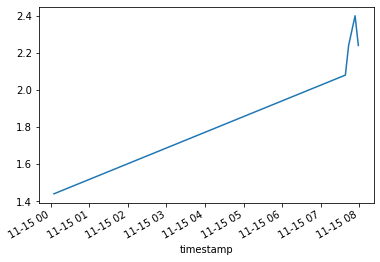

In [19]:
df["2016-11-15":"2016-11-16"]["value"].plot()

Done!

Avec ça, vous êtes prêt pour stocker et récuperer les données de n'importe quel capteur!

Si vous avez des questions n'hésitez pas à contacter :

- Frédéric Montet (frederic.montet@hefr.ch)
- Jonathan Rial (jonathan.rial@hefr.ch)
